# Analyse des années de naissance

In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement
import sparql_functions as spqf

In [4]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  
reload(spqf)

<module 'sparql_functions' from '/Volumes/Patientia/python_notebooks/sciences_historiques_numeriques/histoire_numerique/sparql/sparql_functions.py'>

# Distribution dans le temps de la naissance des économistes de DBPedia

## Analyser les propriétés année ou date de naissance stockées dans la base SQLite


La logique de regroupement: GROUP BY 

* https://www.sqlitetutorial.net/sqlite-group-by/
* https://www.tutorialspoint.com/sqlite/sqlite_group_by.htm



### Récupérer les propriétés 

In [4]:
db = 'data/sparql_queries.db'

In [19]:
### Inspecter le résultat d'une requête après insertion, une fois l'insert ci-dessus effectué


# noter la logique du regroupement : résultat souhaité = une ligne par personne (URI)

query = """
SELECT GROUP_CONCAT(value), uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity
ORDER BY eff DESC ;

"""

# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(query)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:5]

3843


[(',1941-02-21,,1941-02-21',
  'http://dbpedia.org/resource/Laurel_Lunt_Prussing',
  4),
 ('1952-05-27,Tokyo Japan,1952-05-27,Tokyo Japan',
  'http://dbpedia.org/resource/Makoto_Yano',
  4),
 (',1940-09-03,,1940-09-03',
  'http://dbpedia.org/resource/Robert_J._Gordon',
  4),
 ('1899-01-17,1899,1899-01-17',
  'http://dbpedia.org/resource/Abram_Lincoln_Harris',
  3),
 ('1954-06-26,1954,1954-06-26',
  'http://dbpedia.org/resource/Akpan_Hogan_Ekpo',
  3)]

In [ ]:
### inspecter le résultat
ldn = [l[0] for l in result_q]
print(len(ldn))
ldn.sort()
ldn[:50]

### Expressions régulières (regex)

###Documentation Python :
* https://docs.python.org/3/library/re.html

In [20]:
## extraire seulement les années
listeDateNaiss = []
annee = re.compile(r'\d{4}')

for l in result_q:
    listeDateNaiss.append(annee.findall(l[0]))
len(listeDateNaiss)

3843

In [21]:
print(len(listeDateNaiss))

#choix de codage: si plusieurs années par personne, retenir la date inférieure
anneeNaiss = [min(l) for l in listeDateNaiss if l]
print(len(anneeNaiss))

#trier
anneeNaiss.sort()
anneeNaiss[:5]

3843
3821


['0950', '1021', '1031', '1325', '1332']

In [22]:
# codage: retenir seulement les dates supérieures à 1770, i.e. dès 1771
listeAnnees = [int(a) for a in anneeNaiss if a > '1770']

In [23]:
### liste des années issues de la table 'property'
listeAnnees.sort()
print(len(listeAnnees))
print(min(listeAnnees), max(listeAnnees))
listeAnnees[:5]

3752
1771 1988


[1771, 1772, 1772, 1773, 1773]

In [ ]:
### Vérifier que la répétition de 1773 est bien correcte


# ajout de la clause HAVING  qui travaille sur 

query = """
SELECT GROUP_CONCAT(value) valeur, uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity
HAVING valeur like '%1773%'
ORDER BY eff DESC ;
"""

# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(query)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:200]

In [24]:
seriesAnnees = pd.Series(listeAnnees)  # listeAnnees  listeAnneesSPARQL  int_lasp
seriesAnnees

0       1771
1       1772
2       1772
3       1773
4       1773
        ... 
3747    1986
3748    1987
3749    1987
3750    1987
3751    1988
Length: 3752, dtype: int64

In [16]:
### ATTENTION moyenne et écart type n'ont pas de sens dans ce contexte

seriesAnnees.describe()

count    3584.000000
mean     1933.063337
std        36.169295
min      1771.000000
25%      1922.000000
50%      1944.000000
75%      1956.000000
max      1988.000000
dtype: float64

In [25]:
df_annees = pd.DataFrame(seriesAnnees, columns = ['annee'])
df_annees

,annee
0,1771
1,1772
2,1772
3,1773
4,1773
...,...
3747,1986
3748,1987
3749,1987
3750,1987


<AxesSubplot:>

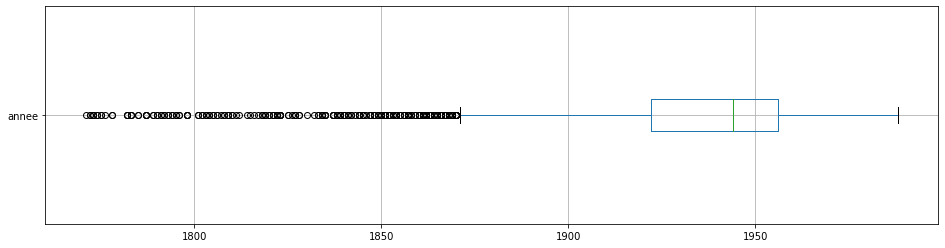

In [26]:
df_annees.boxplot(column=['annee'], vert=False, figsize=(16,4))

## Tester le comportement des graphiques si les données sont lacunaires

__Partie à finalité pédagogique à ne pas reproduire dans le carnet final !__

In [43]:
### Grâce à l'opération modulo on ne retient que les années qui sont multiple de 4
fakeList = [a for a in listeAnnees if a % 4 == 0]
fakeList[10:20]

[1852, 1852, 1852, 1856, 1860, 1860, 1860, 1864, 1864, 1864]

In [72]:
# Compter les naissances par année, utilisation de la fonction Counter
counterFakeListeAnnees = Counter(fakeList)
groupedFakeListeAnnees = list(zip(counterFakeListeAnnees.keys(), counterFakeListeAnnees.values()))
groupedFakeListeAnnees[:10]

[(1808, 1),
 (1828, 1),
 (1840, 3),
 (1844, 3),
 (1848, 1),
 (1852, 4),
 (1856, 1),
 (1860, 3),
 (1864, 4),
 (1868, 3)]

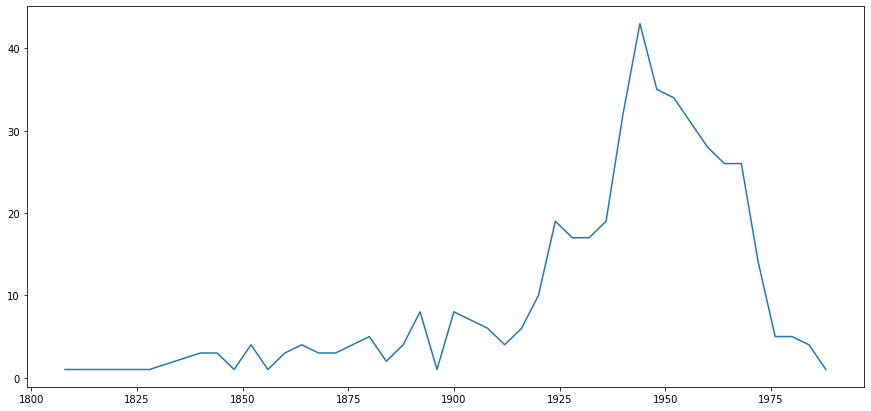

In [45]:
objects = [l[0] for l in groupedFakeListeAnnees]
eff = [l[1] for l in groupedFakeListeAnnees]

plt.figure(figsize=(15,7))
plt.plot(objects, eff)

<BarContainer object of 40 artists>

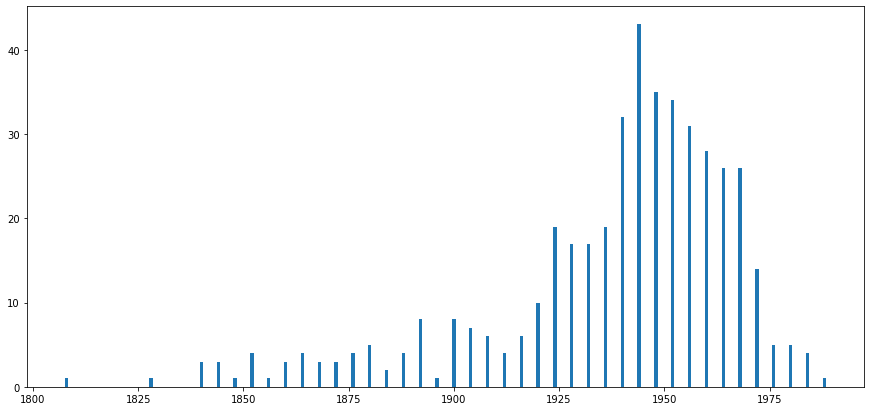

In [46]:
objects = [l[0] for l in groupedFakeListeAnnees]
eff = [l[1] for l in groupedFakeListeAnnees]

plt.figure(figsize=(15,7))
plt.bar(objects, eff)

In [47]:
start = 1801
end = 1992

lYears = []
year = start
while year < end:
    c = 0
    for y in fakeList:
        if y == year:
            c += 1
    lYears.append([year, c]) 
    year += 1
lYears [:40]    

[[1801, 0],
 [1802, 0],
 [1803, 0],
 [1804, 0],
 [1805, 0],
 [1806, 0],
 [1807, 0],
 [1808, 1],
 [1809, 0],
 [1810, 0],
 [1811, 0],
 [1812, 0],
 [1813, 0],
 [1814, 0],
 [1815, 0],
 [1816, 0],
 [1817, 0],
 [1818, 0],
 [1819, 0],
 [1820, 0],
 [1821, 0],
 [1822, 0],
 [1823, 0],
 [1824, 0],
 [1825, 0],
 [1826, 0],
 [1827, 0],
 [1828, 1],
 [1829, 0],
 [1830, 0],
 [1831, 0],
 [1832, 0],
 [1833, 0],
 [1834, 0],
 [1835, 0],
 [1836, 0],
 [1837, 0],
 [1838, 0],
 [1839, 0],
 [1840, 3]]

In [75]:
type(lYears[0][0])

int

In [41]:
l5Years = []
start = 1771
end = 1992

l5Years = []
year = start
while year < end:
    l5Years.append(year) 
    year += 5
l5Years [:10]    

[1771, 1776, 1781, 1786, 1791, 1796, 1801, 1806, 1811, 1816]

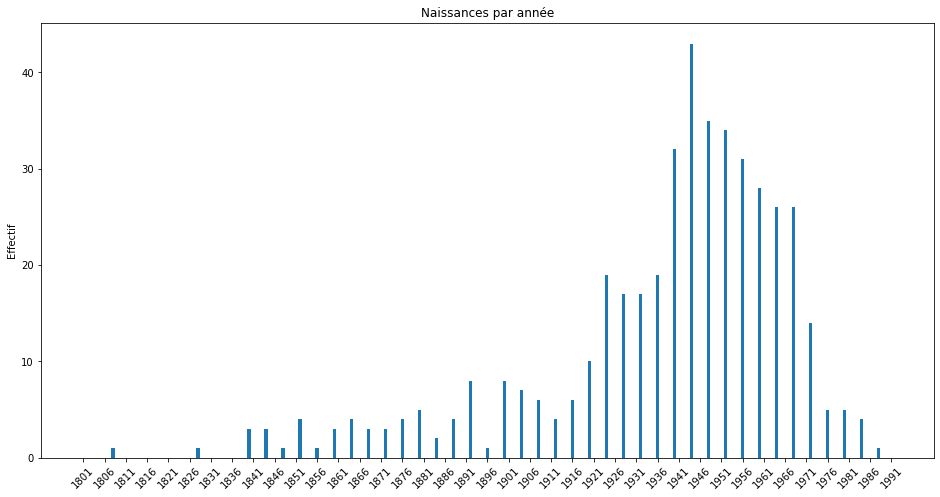

In [49]:
# Distribution par année

objects = [l[0] for l in lYears]
eff = [l[1] for l in lYears]

p1 = plt.bar(objects, eff)

plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Naissances par année')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Distribution des naissances par année et par période de 20 ans

#### Regroupement des vraies valeurs par année

In [30]:
# Compter les naissances par année
counterListeAnnees = Counter(listeAnnees)
groupedListeAnnees = list(zip(counterListeAnnees.keys(), counterListeAnnees.values()))

In [31]:
groupedListeAnnees[75:90]

[(1861, 8),
 (1862, 6),
 (1863, 5),
 (1864, 5),
 (1865, 5),
 (1866, 8),
 (1867, 9),
 (1868, 4),
 (1869, 6),
 (1870, 7),
 (1871, 2),
 (1872, 6),
 (1873, 9),
 (1874, 11),
 (1875, 7)]

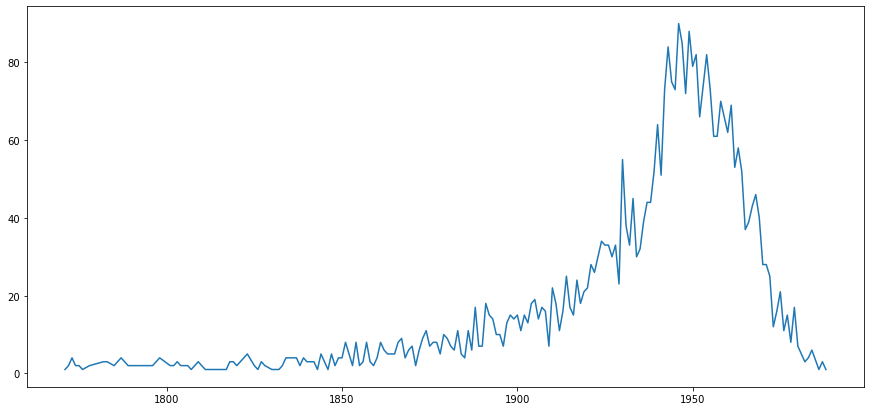

In [32]:
objects = [l[0] for l in groupedListeAnnees]
eff = [l[1] for l in groupedListeAnnees]

plt.figure(figsize=(15,7))
plt.plot(objects, eff)

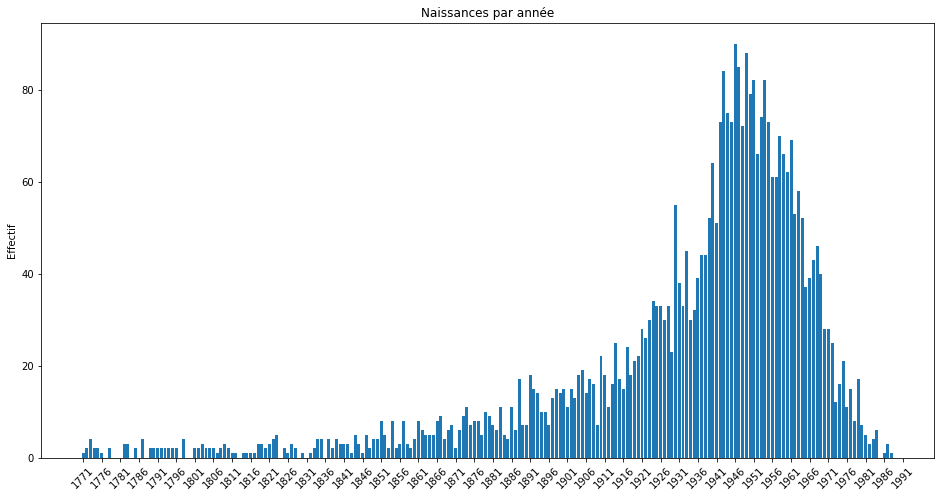

In [42]:
# Distribution par année

objects = [l[0] for l in groupedListeAnnees]
eff = [l[1] for l in groupedListeAnnees]

p1 = plt.bar(objects, eff)

plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Naissances par année')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


## Regroupement des valeurs par 20 ans - diagramme final

In [34]:
### Créer la liste des périodes de 20 ans, i.e. la liste de la première année de chaque période
d20List = []
period = 20
d_start = 1801
i = 0
d20List.append(d_start)

while i < 10:
    d_start = d_start + period
    d20List.append(d_start)
    i += 1

In [35]:
print(d20List[:2])
min(d20List), max(d20List)

[1801, 1821]


(1801, 2001)

In [36]:
# Regroupement par période de 20 ans
i20List = []
for i in d20List:
    i_n = 0
    for l in groupedListeAnnees:
        if l[0] >= i and l[0] < (i + 20):
            i_n = i_n + l[1]
    i20List.append([i, i_n])        

In [37]:
i20List[5]

[1901, 339]

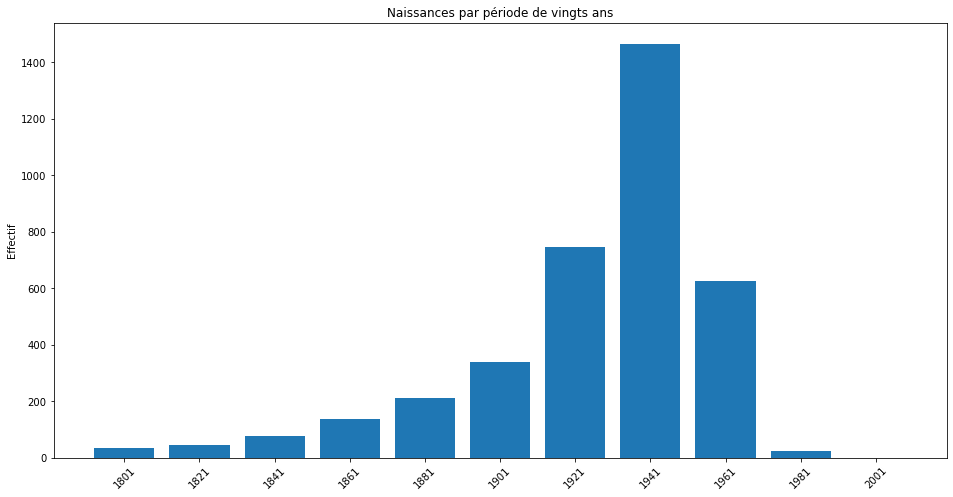

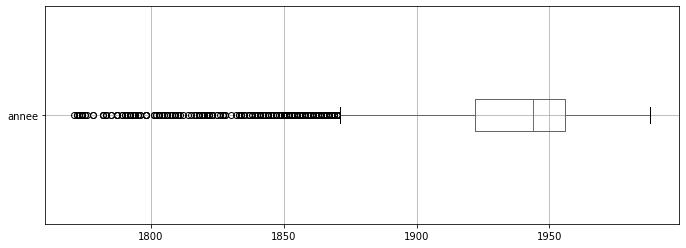

In [38]:
# Distribution par période de 20 ans

objects = [str(l[0]) for l in i20List]
eff = [l[1] for l in i20List]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingts ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

pt = df_annees.boxplot(column=['annee'], vert=False, figsize=(16,4))
### https://www.pythonprogramming.in/boxplot-adjust-bottom-and-left.html
#ax = fig.add_subplot()
plt.subplots_adjust(left=0.35) 
plt.show()

# Exploration interactive

Partie exploratoire qui n'est pas partie du programme à réaliser par les étudiant-e-s

In [43]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider,
    interactive)
"""    fixed,
    interactive, Button,
    HTML, Layout,GridspecLayout,
    Output, jslink,
     ColorPicker,
    Text, SelectionRangeSlider,
    FloatRangeSlider, SelectMultiple, Checkbox,
    VBox, HBox
"""

'    fixed,\n    interactive, Button,\n    HTML, Layout,GridspecLayout,\n    Output, jslink,\n     ColorPicker,\n    Text, SelectionRangeSlider,\n    FloatRangeSlider, SelectMultiple, Checkbox,\n    VBox, HBox\n'

In [44]:
### Create a list with intervals of 20 years, corresponding approximately to one generation.

def create_years_list(period = 20, y_start = 1391, y_end = 1801):

    y_list = []
    y_list.append(y_start)

    while y_start < y_end:
        y_start += period
        y_list.append(y_start)
    return y_list    

In [45]:
# Distribution by 10 years periods
def interactive_periods(period=10):
    
    y_list = create_years_list(period = period, y_start = 1771, y_end = 2021)

    i_list = []
    for i in y_list:
        i_n = 0
        for y in listeAnnees:
            if y >= i and y < (i + period):
                i_n += 1
        i_list.append([i, i_n]) 

    periods = [e[0] for e in i_list]
    eff = [e[1] for e in i_list]

    p1 = plt.bar(periods, eff, width= period - (period * 20 / 100))

    plt.xticks([i - period / 2 for i in y_list])
    plt.ylabel('Frequency')
    plt.title('Births per '+ str(period) +' years')
    plt.gcf().set_size_inches(14, 7)
    #plt.gca().axes.get_xaxis().set_visible(False)
    # supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
    #plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
    plt.xticks(rotation=45)
    plt.show()


In [46]:
i = interact(interactive_periods, period=IntSlider(min=5, max=100, step=5, value=20))

interactive(children=(IntSlider(value=20, description='period', min=5, step=5), Output()), _dom_classes=('widg…